In [1]:
import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ[ 'NUMBA_CACHE_DIR' ] = '/tmp/'
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import scimap as sm
import scanpy.external as sce
from pyensembl import EnsemblRelease
from pyensembl import Genome

Running SCIMAP  2.0.3


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.10.1 anndata==0.10.7 umap==0.5.5 numpy==1.26.4 scipy==1.11.0 pandas==1.5.3 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.10.8 pynndescent==0.5.12


In [4]:
n_neighbors=10
n_pcs=40
resolution = 0.5

In [5]:
#os.chdir('/gpfs/gibbs/project/kleinstein/jx299/')
#os.chdir('/Volumes/COKETOM/transfer')

In [6]:
#SRR = ['SRR14219617','SRR14219618','SRR14219619','SRR14219620','SRR14219621','SRR14219622','SRR14219623','SRR14219624']
#SRR = ['SRR14219617','SRR14219618','SRR14219619','SRR14219620']
#SRR = ['SRR14219617','SRR14219618','SRR14219619','SRR14219620','SRR18922767','SRR18922768','SRR18922769','SRR18922770']

In [ ]:
filelist_all = os.listdir("./")

filelist = [x for x in filelist_all if x.endswith("h5")]

In [ ]:
SRR = [os.path.splitext(os.path.basename(file))[0] for file in filelist]

In [7]:
adatas = [sc.read_h5ad(os.path.splitext(os.path.basename(file))[0]+'.h5ad') for file in filelist]

### Normalization and log transformation

In [8]:
for i in range(len(adatas)):
    sc.pp.normalize_total(adatas[i], target_sum=1e4)
    sc.pp.log1p(adatas[i])
    #sc.pp.scale(adatas[i], max_value=10)

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


In [9]:
adatas_raw = adatas

### Remove tr and ig genes from gene features

In [ ]:
!pyensembl install --release 111 --species human

In [10]:
data = EnsemblRelease(release=111, species='human')
gene_ids = data.gene_ids()

In [12]:
genes = [data.gene_by_id(gene_id) for gene_id in gene_ids]

In [13]:
tr_ig_genes = [gene for gene in genes if gene.biotype in ["TR_C_gene", "TR_D_gene","TR_J_gene", 
                                                           "TR_J_pseudogene","TR_V_gene", "TR_V_pseudogene","IG_C_gene", "IG_C_pseudogene","IG_D_gene", 
                                                           "IG_D_pseudogene","IG_J_gene", "IG_LV_gene", "IG_pseudogene","IG_V_gene","IG_V_pseudogene"]]

In [14]:
lst1 = [tr_ig_genes[i].gene_id for i in range(len(tr_ig_genes))]
lst2 = [tr_ig_genes[i].gene_name for i in range(len(tr_ig_genes))]
feature=pd.DataFrame(
    {'es':lst1,
     'id':lst2
    }
)

In [15]:
for i in range(len(adatas)):
  num = adatas[i].var.gene_ids.to_numpy()
  list = feature.loc[feature['es'].isin(num)]
  boom = list.id.to_numpy()
  adatas[i]=sm.hl.dropFeatures(adatas[i], drop_markers= boom ,subset_raw=False)

### Identify highly-variable genes

In [16]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display

# Configure matplotlib for inline display
%matplotlib inline

In [17]:
tab = widgets.Tab()
children = []

for i, adata in enumerate(adatas):
    plt.figure(figsize=(8, 6))
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    sc.pl.highly_variable_genes(adata, show=False)
    
    # Capture the plot output
    plot_widget = widgets.Output()
    with plot_widget:
        plt.figure(figsize=(8, 6))
        plt.show();
    
    children.append(plot_widget)
    plt.close()

# Setting the children for the tab
tab.children = children

# Naming each tab
for i in range(len(children)):
    tab.set_title(i, f'{SRR[i]}')

# Display the tab widget
display(tab)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
extracting h

### Principal component analysis

In [18]:
tab = widgets.Tab()
children = []

for i, adata in enumerate(adatas):
    plt.figure(figsize=(8, 6))
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca_variance_ratio(adata, log=True, show=False)
    
    # Capture the plot output
    plot_widget = widgets.Output()
    with plot_widget:
        plt.figure(figsize=(8, 6))
        plt.show();
    
    children.append(plot_widget)
    plt.close()

# Setting the children for the tab
tab.children = children

# Naming each tab
for i in range(len(children)):
    tab.set_title(i, f'{SRR[i]}')

# Display the tab widget
display(tab)

computing PCA
    with n_comps=50
    finished (0:00:01)
computing PCA
    with n_comps=50
    finished (0:00:01)
computing PCA
    with n_comps=50
    finished (0:00:01)
computing PCA
    with n_comps=50
    finished (0:00:01)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:01)
computing PCA
    with n_comps=50
    finished (0:00:01)
computing PCA
    with n_comps=50
    finished (0:00:00)


### Computing the neighborhood graph

In [19]:
for i in range(len(adatas)):
  if n_neighbors is not None:
    if n_pcs is not None:
      sc.pp.neighbors(adatas[i], n_neighbors = n_neighbors, n_pcs=n_pcs)
    else: sc.pp.neighbors(adatas[i], n_neighbors = n_neighbors, n_pcs=40)
  else: sc.pp.neighbors(adatas[i], n_neighbors = 10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbor

### Embedding and clustering the neighborhood graph

In [20]:
for i in range(len(adatas)):
  sc.tl.umap(adatas[i])
  if resolution is not None:
    sc.tl.leiden(adatas[i],resolution=resolution)
  else: sc.tl.leiden(adatas[i],resolution=0.2)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)
running Lei

In [21]:
tab = widgets.Tab()
children = []

for i, adata in enumerate(adatas):
    plt.figure(figsize=(8, 6))
    sc.pl.umap(adata, color=['leiden'],show =False)
    
    # Capture the plot output
    plot_widget = widgets.Output()
    with plot_widget:
        plt.figure(figsize=(8, 6))
        plt.show();
    
    children.append(plot_widget)
    plt.close()

# Setting the children for the tab
tab.children = children

# Naming each tab
for i in range(len(children)):
    tab.set_title(i, f'{SRR[i]}')

# Display the tab widget
display(tab)


### Cell type annotation

In [22]:
import singler
import singlecellexperiment as scet
for i in range(len(adatas_raw)):
    data = adatas_raw[i]
    mat = data.X.transpose()
    features = data.var_names
    result = singler.annotate_single(
    mat,
    features,
    ref_data = "BlueprintEncode",
    ref_features = "symbol",
    ref_labels = "main",
    cache_dir = "_cache")
    adatas_raw[i].obs['cell_type'] = result.column("best")

{'markers': {'Adipocytes': {'Adipocytes': [], 'Astrocytes': ['GPD1', 'CD36', 'CFD', 'G0S2', 'LPL', 'GPX3', 'RNASE1', 'ACACB', 'C1QB', 'PDK4', 'CIDEC', 'PLIN4', 'S100A4', 'SAA1', 'LIPE', 'CD163', 'SPARCL1', 'C3', 'C1QA', 'LEP', 'VSIG4', 'C1QC', 'S100A9', 'CD74', 'CYP4B1', 'HLA-DRA', 'TYROBP', 'MS4A6A', 'GHR', 'CEBPA', 'STAB1', 'AQP7', 'MME', 'ZBTB16', 'AOX1', 'C7', 'SERPING1', 'MRC1', 'VWF', 'ABCA6', 'ANGPTL4', 'RASD1', 'CLEC3B', 'CCDC69', 'SVEP1', 'FCER1G', 'TNXB', 'HBB', 'CD302', 'FKBP5', 'GLUL', 'C1QTNF1', 'HBA1', 'PECAM1', 'GYG2', 'LYVE1'], 'B-cells': ['GPX3', 'GPD1', 'CD36', 'GLUL', 'CFD', 'CLU', 'G0S2', 'LPL', 'FHL1', 'ANXA1', 'FSTL1', 'RNASE1', 'CST3', 'SPARC', 'MGST1', 'TIMP3', 'GSN', 'C1QB', 'PDK4', 'NNMT', 'MCAM', 'CIDEC', 'COL6A2', 'THBS1', 'IGFBP3', 'SCD', 'EMP1', 'SERPING1', 'PLIN4', 'MAP1B', 'COL6A1', 'COL4A1', 'IGFBP6', 'C3', 'LRP1', 'SAA1', 'COL4A2', 'MMP2', 'CAV1', 'COL6A3', 'CD163', 'IGFBP7', 'C1S', 'SPARCL1', 'LAMB1', 'LAMB2', 'LAMA4', 'MT1E', 'MT1X', 'CYBRD1', 'SORBS

In [23]:
for i in range (len(adatas)):
    adatas[i].obs['cell_type'] = adatas_raw[i].obs['cell_type']

### Integration

In [24]:
adatas_concat = ad.concat([adatas[i] for i in range(len(adatas))], join="inner",index_unique="-",keys= SRR)

extracting highly variable genes


... storing 'cell_type' as categorical


    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


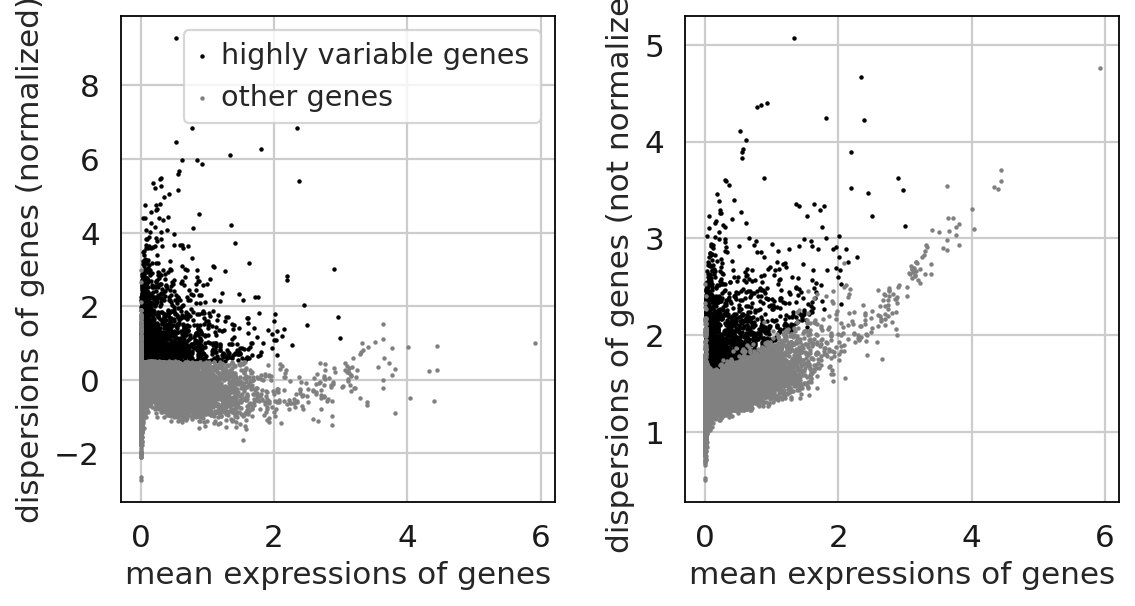

In [25]:
sc.pp.highly_variable_genes(adatas_concat, min_mean=0.0125, max_mean=3, min_disp=0.5,batch_key="sample")
sc.pl.highly_variable_genes(adatas_concat)

In [26]:
var_select = adatas_concat.var.highly_variable_nbatches > 2
var_genes = var_select.index[var_select]

In [27]:
adatas_concat = adatas_concat[:,var_genes]

In [28]:
sc.pp.pca(adatas_concat)
sc.pp.neighbors(adatas_concat)
sc.tl.umap(adatas_concat)
sc.tl.leiden(adatas_concat)

computing PCA
    with n_comps=50
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:03)
running Leiden clustering
    finished: found 23 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:59)


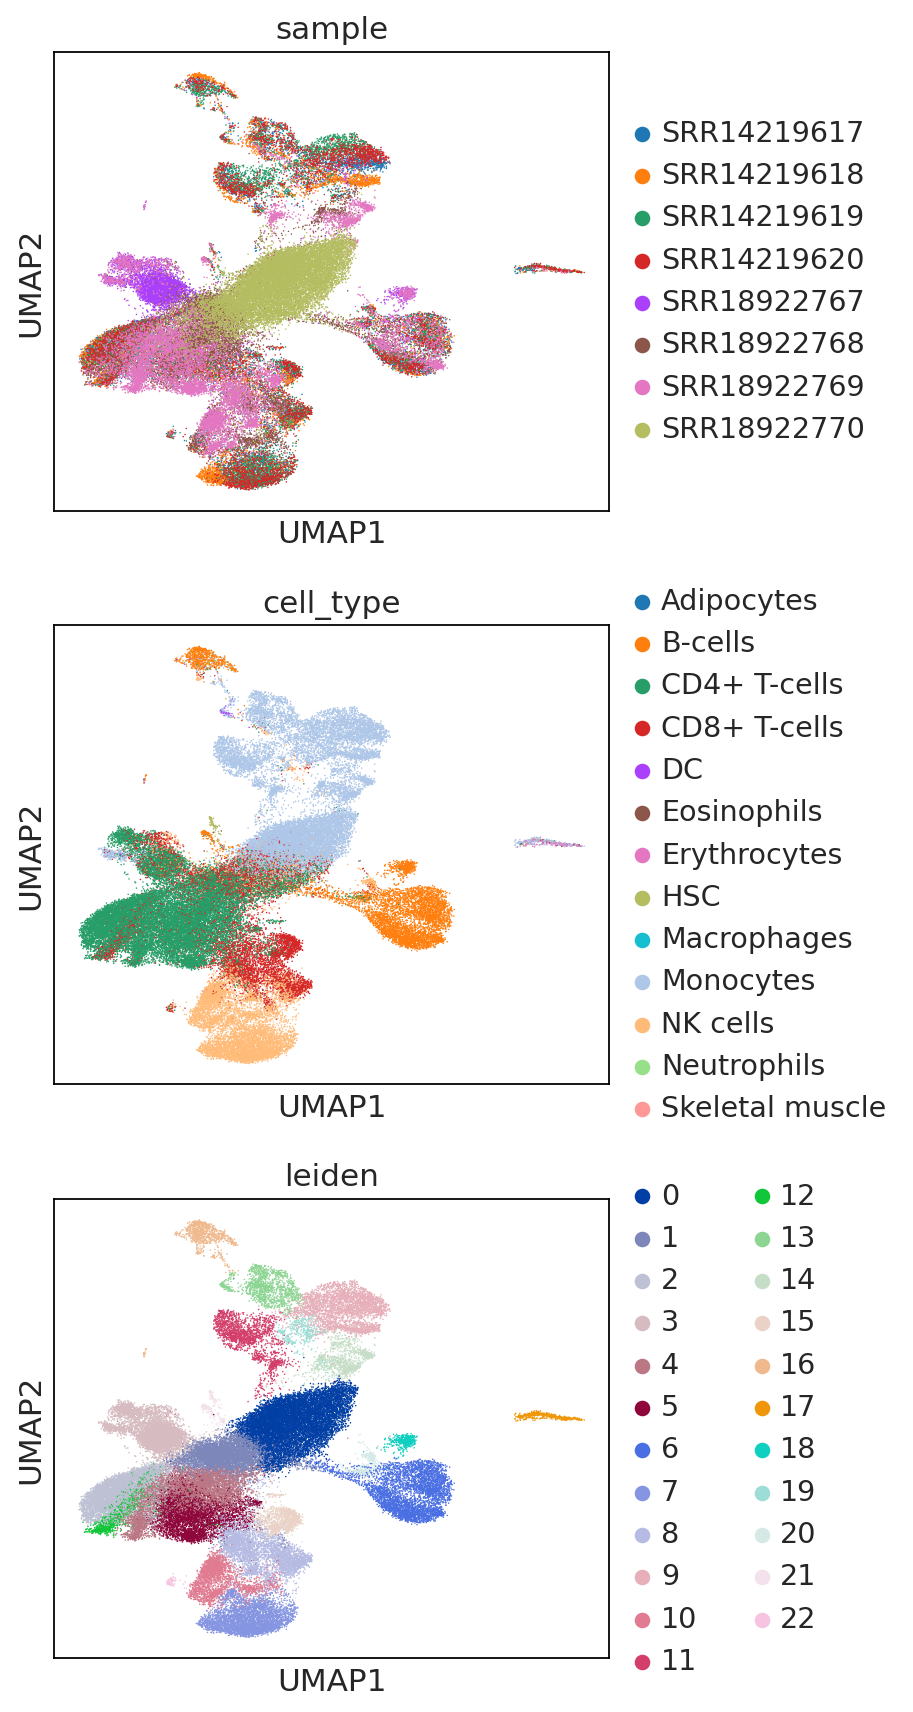

In [29]:
sc.pl.umap(adatas_concat, color=["sample", "cell_type","leiden"],ncols=1)

In [30]:
adatas_concat3=adatas_concat

In [31]:
sce.pp.harmony_integrate(adatas_concat3, 'sample')

2024-05-22 18:58:44,207 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2024-05-22 18:58:59,525 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2024-05-22 18:58:59,805 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2024-05-22 18:59:25,365 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2024-05-22 18:59:49,195 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2024-05-22 19:00:13,128 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2024-05-22 19:00:36,125 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2024-05-22 19:00:59,236 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2024-05-22 19:01:21,142 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2024-05-22 19:01:43,019 - 

In [32]:
sc.pp.neighbors(adatas_concat3, n_pcs =30, use_rep = "X_pca_harmony")
sc.tl.umap(adatas_concat3)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:02)


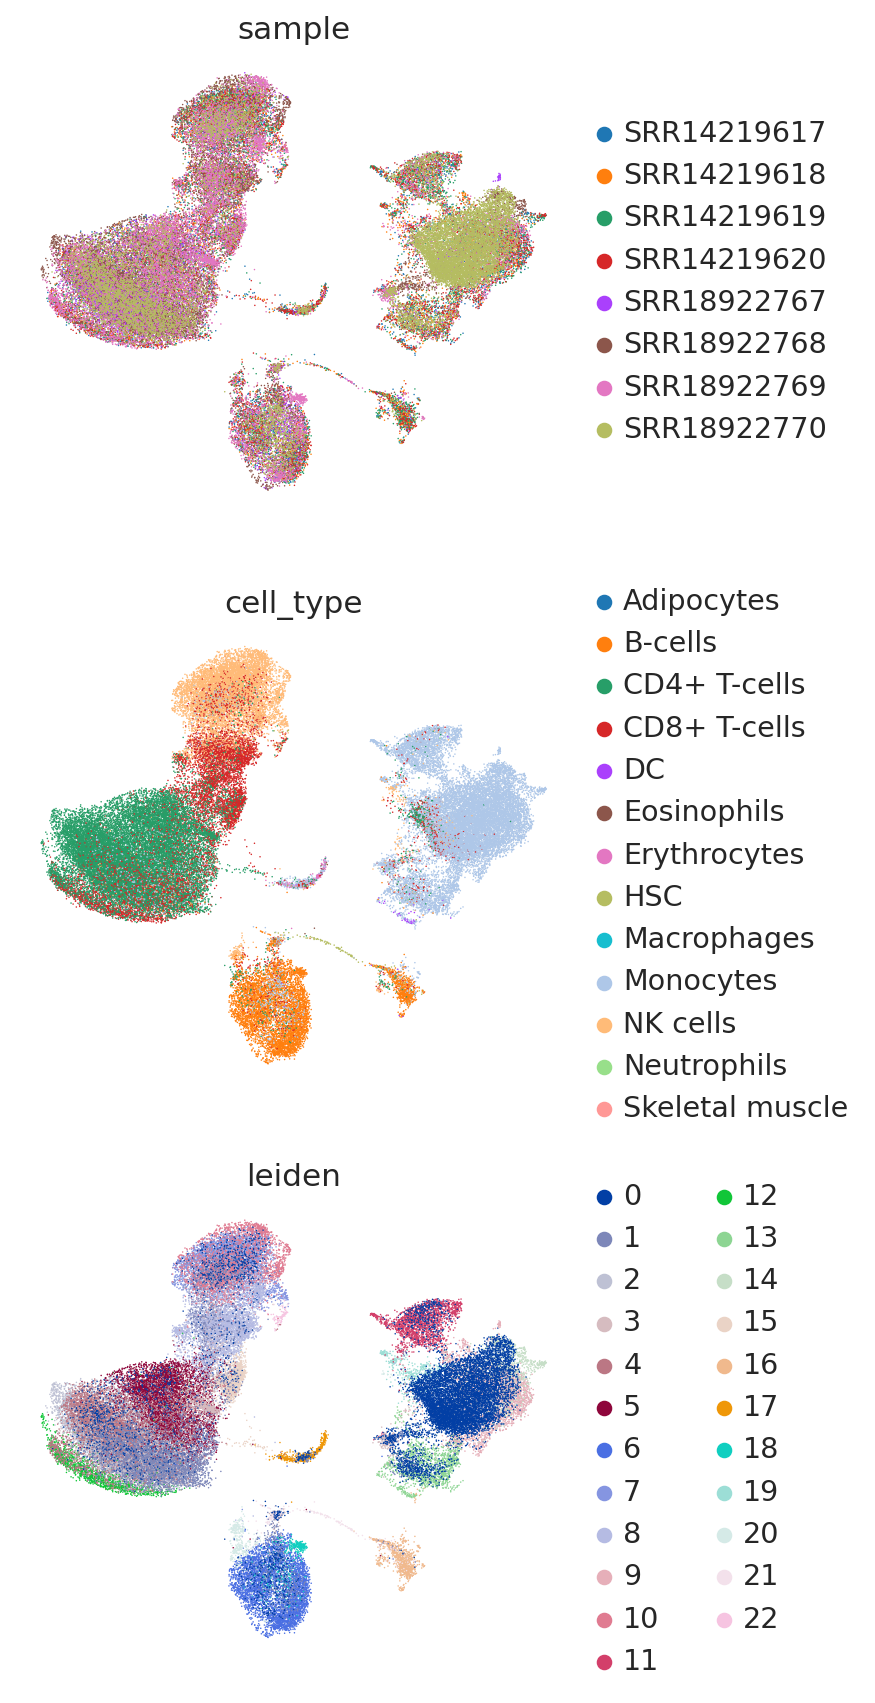

In [33]:
sc.pl.umap(adatas_concat3, color=["sample", "cell_type","leiden"], frameon=False, ncols=1)

In [34]:
adatas_concat

AnnData object with n_obs × n_vars = 65003 × 3409
    obs: 'sample', 'species', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'sample_colors', 'cell_type_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [36]:
import scCRAFT
from scCRAFT.model import *

In [37]:
adatas_concat4=adatas_concat

In [38]:
multi_resolution_cluster(adatas_concat4, resolution1 = 0.5, method = 'Leiden')

computing PCA
    with n_comps=50
    finished (0:00:06)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
running Leiden clustering


/home/jx299/.conda/envs/py/lib/python3.10/site-packages/scCRAFT/utils.py:169: FutureWarning:

In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.



    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:40)
running Leiden clustering
    finished: found 101 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:02:04)


In [39]:
VAE = train_integration_model(adatas_concat4, batch_key = 'sample', epochs = 150, d_coef = 0.2, kl_coef = 0.005, warmup_epoch = 50)
obtain_embeddings(adatas_concat4, VAE)

150


Overall Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training completed in 1952.68 seconds


AnnData object with n_obs × n_vars = 65003 × 3401
    obs: 'sample', 'species', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type', 'leiden1', 'leiden2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'neighbors', 'umap', 'sample_colors', 'cell_type_colors', 'leiden_colors', 'hvg', 'pca', 'leiden'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony', 'X_scCRAFT'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:58)


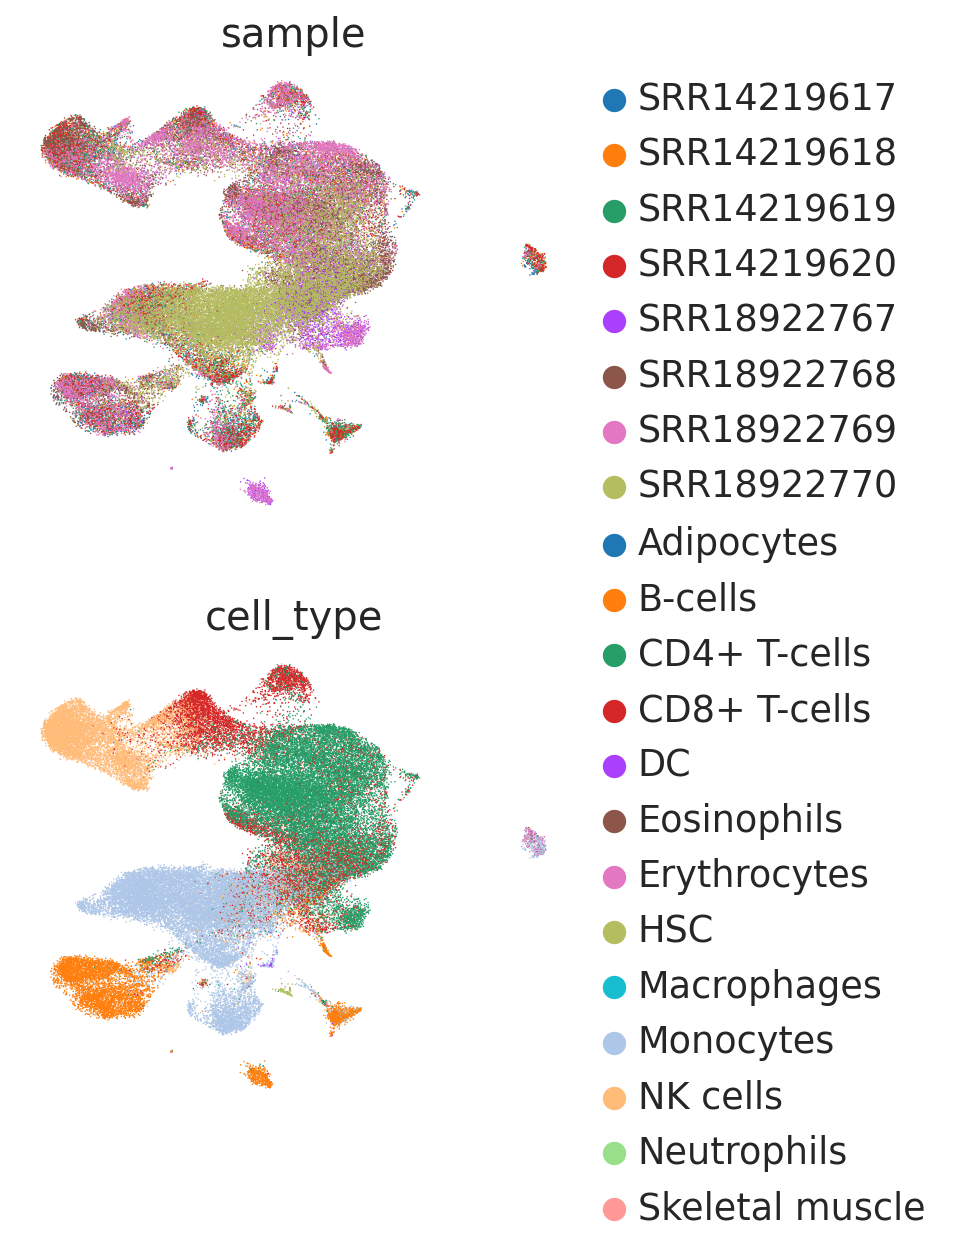

In [40]:
sc.pp.neighbors(adatas_concat4, use_rep="X_scCRAFT")
sc.tl.umap(adatas_concat4, min_dist=0.5)
sc.pl.umap(adatas_concat4, color=['sample', 'cell_type'], frameon=False, ncols=1)

### Clustree

In [35]:
from clustree import clustree

In [115]:
parares = [0.1,0.3,0.5,0.7,0.9]

In [116]:
for i in range(len(adatas)):
  globals()['df'+str(i)]=pd.DataFrame({'cell':adatas[i].obs.leiden.index})
  #for res in np.linspace(1,0.5,5):
  for res in parares:
    sc.tl.leiden(adatas[i],resolution=res)
    df=pd.DataFrame(adatas[i].obs.leiden.values)
    globals()['df'+str(i)] = pd.concat([globals()['df'+str(i)],df], axis=1)
    #globals()['df'+str(i)] = globals()['df'+str(i)].join(globals()['df'+str(res)])

running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 22 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 17 

In [52]:
df=pd.DataFrame({'cell':adatas_concat3.obs.leiden.index})
for res in parares:
  sc.tl.leiden(adatas_concat3,resolution=res)
  dm=pd.DataFrame(adatas_concat3.obs.leiden.values)
  df=pd.concat([df,dm],axis=1)

running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:29)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:36)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:01:00)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:01:03)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:01:00)


In [117]:
parares = ['K_' + str(num) for num in parares]

In [118]:
parares.insert(0,"cell")

In [119]:
for i in range(len(adatas)):
    globals()['df'+str(i)].columns = parares
    globals()['df'+str(i)].set_index("cell", inplace = True)

In [56]:
df.columns = parares
df.set_index("cell", inplace = True)

In [120]:
for i in range(len(adatas)):
    globals()['df'+str(i)]=globals()['df'+str(i)].astype("int")
    globals()['df'+str(i)]+=1
    #globals()['df'+str(i)]=globals()['df'+str(i)].sort_values(by=['K1'],ascending=True)

In [57]:
df=df.astype("int")
df+=1

In [121]:
for i in range(len(adatas)):
    globals()['df'+str(i)]=globals()['df'+str(i)].astype("category")

In [60]:
df=df.astype("category")

In [112]:
import logging
from rpy2.rinterface_lib import callbacks

# Set the logging level to ERROR to suppress warnings
logging.getLogger('rpy2').setLevel(logging.ERROR)

# You might specifically want to target rpy2.rinterface
logging.getLogger('rpy2.rinterface').setLevel(logging.ERROR)

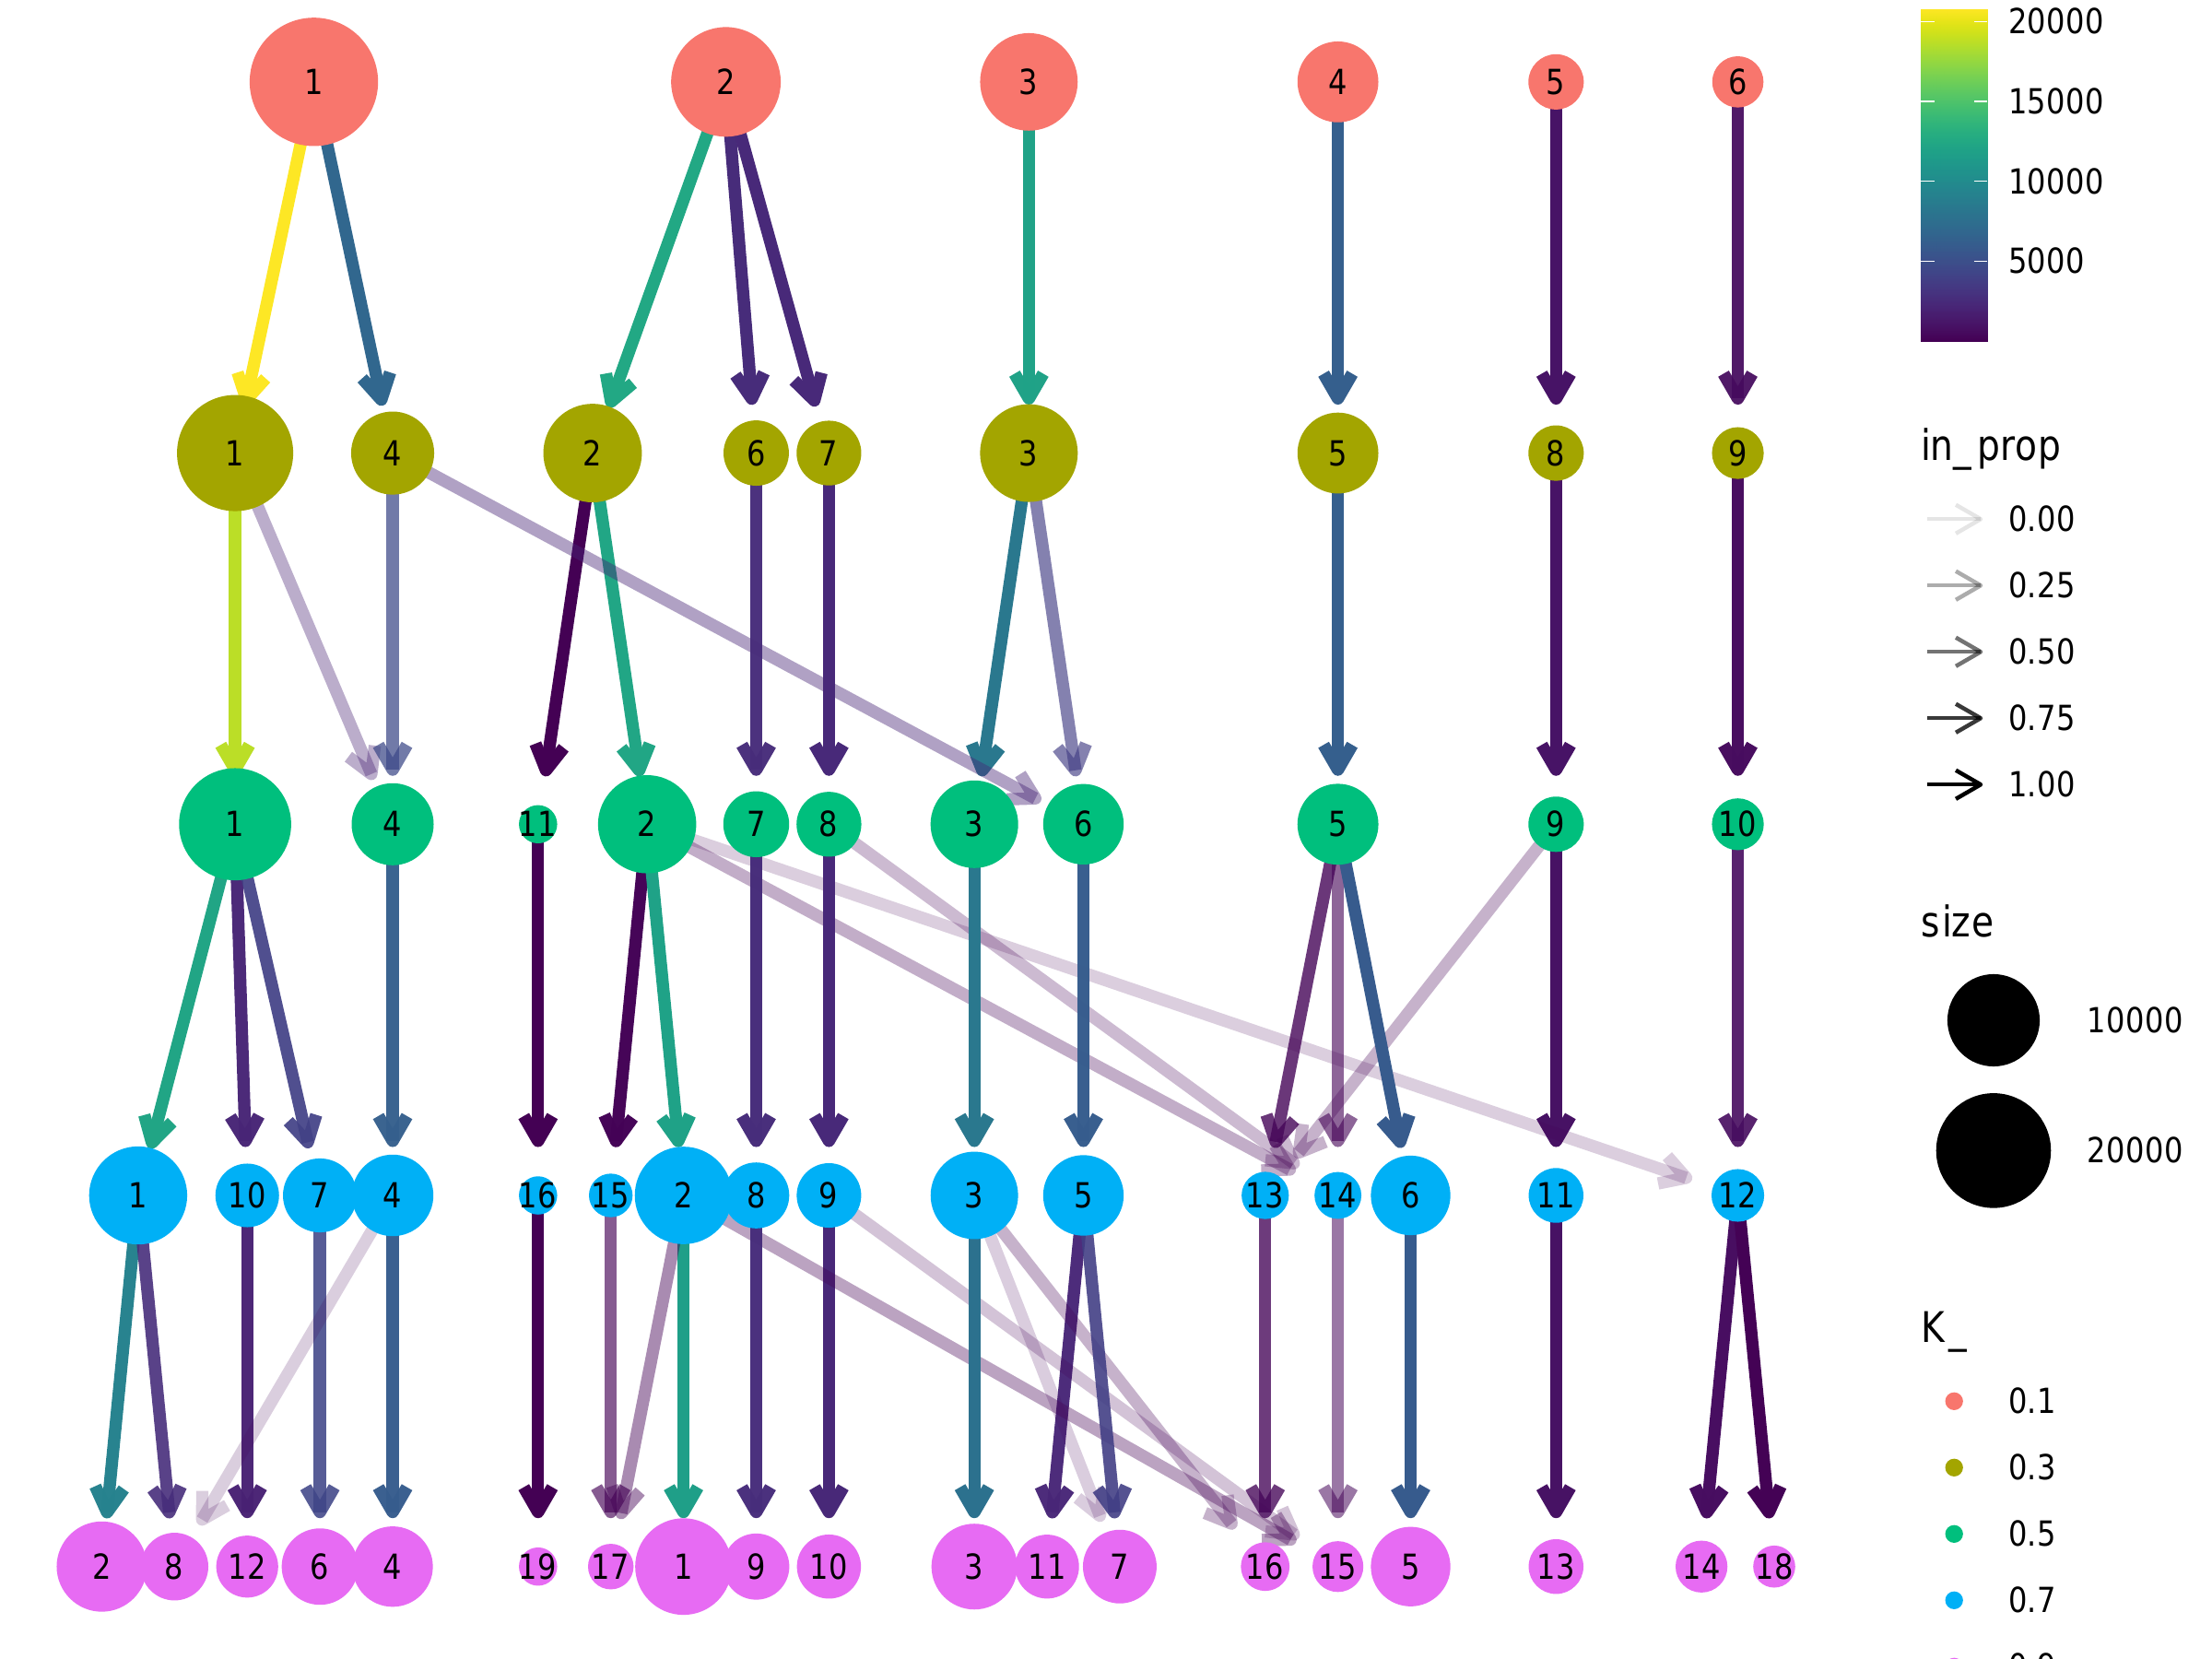

In [109]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from IPython.display import Image, display
import ipywidgets as widgets  # Import ipywidgets for the tab functionality

# Ensure pandas to R conversion is activated
pandas2ri.activate()

# Convert pandas DataFrame to R DataFrame
r_df = pandas2ri.py2rpy(df)

# Import R packages
clustree = importr('clustree')
ggplot2 = importr('ggplot2')
ro.r('library(Cairo)')  # Load Cairo for high-quality graphics

# Define the clustree plot function in R
ro.r('''
clustree_plot <- function(df, filename) {
  # Open a PDF graphics device
  pdf(filename, width = 8, height = 6)  # Width and height in inches
  plot <- clustree(df, prefix = "K_")
  print(plot)
  dev.off()  # Close the PDF device
}
''')

# Prepare to plot
filename = 'clustree_plot_concat.pdf'
ro.globalenv['df'] = r_df
ro.globalenv['filename'] = filename

# Run the plotting function and display the result
ro.r('clustree_plot(df, filename)')

# Display the resulting image in Jupyter Notebook
from pdf2image import convert_from_path
from IPython.display import display, Image

pages = convert_from_path(filename, 300)
page = pages[0]
page

In [124]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from IPython.display import display
import ipywidgets as widgets
import subprocess

# Activate conversion from pandas to R dataframes
pandas2ri.activate()

# Assuming 'adatas' contains your dataframes
aadatas = [globals().get(f'df{i}') for i in range(len(adatas))]

# Convert dataframes to R dataframes
r_dfs = [pandas2ri.py2rpy(df) for df in aadatas]

# Import R packages
clustree = importr('clustree')
ggplot2 = importr('ggplot2')
ro.r('library(Cairo)')

# Define the clustree plotting function in R
ro.r('''
clustree_plot <- function(df, filename) {
  pdf(filename, width = 8, height = 6)
  plot <- clustree(df, prefix = "K_")
  print(plot)
  dev.off()
}
''')

# Create a tab widget to hold the images
tab = widgets.Tab()
children = []

# Run clustree and prepare images for tabs
for i, r_df in enumerate(r_dfs):
    pdf_filename = f'clustree_plot_{i}.pdf'
    png_filename = f'clustree_plot_{i}.png'
    ro.globalenv['df'] = r_df
    ro.globalenv['filename'] = pdf_filename
    ro.r('clustree_plot(df, filename)')
    
    # Convert PDF to PNG
    subprocess.run(['magick', 'convert', '-density', '300', pdf_filename, png_filename])
    
    # Read the PNG file and create an Image widget
    with open(png_filename, "rb") as file:
        image_widget = widgets.Image(value=file.read(), format='png', width=500, height=400)
        children.append(image_widget)

tab.children = children  # Assign image widgets to the tab

# Optionally set titles if SRR is defined and lengths match
if 'SRR' in globals() and len(SRR) == len(children):
    for index, title in enumerate(SRR):
        tab.set_title(index, title)

# Display the tab widget
display(tab)